In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

## Add tools

In [2]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)
tools = [tool]

In [3]:
from langchain_openai import ChatOpenAI
import os
from langchain.chat_models import init_chat_model

os.environ["OPENAI_API_KEY"] = "none"

llm = init_chat_model(
    model="google/gemma-3-4b",
    temperature=0.1,
    base_url="http://localhost:1234/v1/",
    model_provider="openai",
)

llm_with_tools = llm.bind_tools(tools)


def chatBot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatBot)

## Tool Node

In [4]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

## Compile Graph

In [5]:

def route_tools(
    state: State | list  # Allow state to be a list of messages for compatibility,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    # If no tool calls, return END to indicate no tools are needed
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

# Chat bot loop

In [6]:
from langchain_core.messages import AIMessage

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            if isinstance( value["messages"][-1], AIMessage) and value["messages"][-1].tool_calls:
               print("Tool calls:", value["messages"][-1].tool_calls)
            else:
                print("Agent:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Tool calls: [{'name': 'tavily_search', 'args': {'query': 'best asian stir fry recipes'}, 'id': '836973096', 'type': 'tool_call'}]
Agent: {"query": "best asian stir fry recipes", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "36 Asian Stir-Fry Recipes That Won't Have You Missing Takeout", "url": "https://www.tasteofhome.com/collection/best-stir-fry-recipes/", "content": "There's no need for take-out when you have these Asian stir fry recipes at your fingertips. Find chicken, beef, seafood and vegetable stir fry recipes right here.", "score": 0.7938904, "raw_content": null}, {"title": "Our 25 Best Stir-Fry Recipes", "url": "https://www.allrecipes.com/gallery/best-stir-fry-recipes/", "content": "Our most popular stir-fry recipe is a classic Chinese restaurant dish you can make at home in just 20 minutes.\"You have to give anything this fast, healthy and so full of flavor a 5. Note this isn't a recipe for small children or others with a tongue that can't 

## Visualize

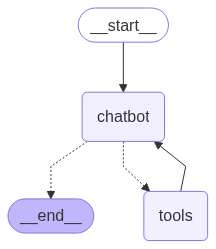

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass